<a href="https://colab.research.google.com/github/hadiahmed1/MalariaDetection/blob/main/MalariaDiagnosis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria Diagnosis

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

## Data Prepration

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteE7FBBW/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO=0.8
VAL_RATIO=0.1
TEST_RATIO=0.1
#dataset=tf.data.Dataset.range(10)
train_dataset,val_dataset,test_dataset=splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]


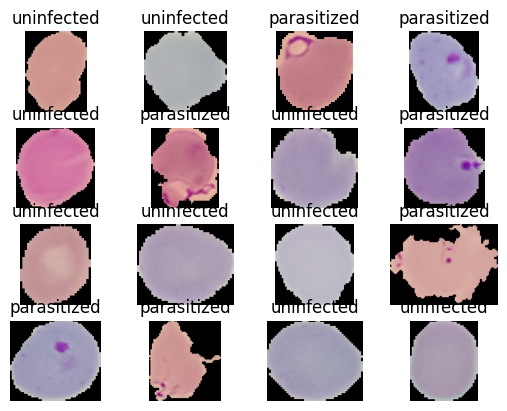

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

## Data Processing

In [ ]:
def resize_rescale(image,label):
  return tf.image.resize(image,(224,224))/255,label

In [ ]:
train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)

In [ ]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
train_dataset=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

## Model

In [ ]:
model=tf.keras.Sequential([
    InputLayer(input_shape=(224,224,3)),
    Conv2D(filters=6,kernel_size=3,strides=(1, 1),padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Conv2D(filters=16,kernel_size=5,strides=(1, 1),padding='valid',activation='relu'),
    MaxPool2D(pool_size=2,strides=2),
    BatchNormalization(),
    Flatten(),
    Dense(100,activation='relu'),
    BatchNormalization(),
    Dense(10,activation='relu'),
    BatchNormalization(),
    Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 16)      2416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 53, 53, 16)        0         
 g2D)                                                            
                                                      

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.1),
              loss=BinaryCrossentropy(),
              metrics='accuracy'
)

In [ ]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1)

Epoch 1/20
689/689 [==============================] - 51s 67ms/step - loss: 0.2332 - accuracy: 0.9296 - val_loss: 0.2298 - val_accuracy: 0.9321
Epoch 2/20
689/689 [==============================] - 51s 74ms/step - loss: 0.1968 - accuracy: 0.9413 - val_loss: 0.2443 - val_accuracy: 0.9285
Epoch 3/20
689/689 [==============================] - 53s 77ms/step - loss: 0.2041 - accuracy: 0.9385 - val_loss: 0.3844 - val_accuracy: 0.8497
Epoch 4/20
689/689 [==============================] - 49s 71ms/step - loss: 0.1801 - accuracy: 0.9468 - val_loss: 0.8027 - val_accuracy: 0.9376
Epoch 5/20
689/689 [==============================] - 52s 75ms/step - loss: 0.1919 - accuracy: 0.9427 - val_loss: 0.1992 - val_accuracy: 0.9510
Epoch 6/20
689/689 [==============================] - 45s 66ms/step - loss: 0.1743 - accuracy: 0.9481 - val_loss: 0.2272 - val_accuracy: 0.9223
Epoch 7/20
689/689 [==============================] - 51s 74ms/step - loss: 0.1611 - accuracy: 0.9528 - val_loss: 0.1931 - val_accuracy:

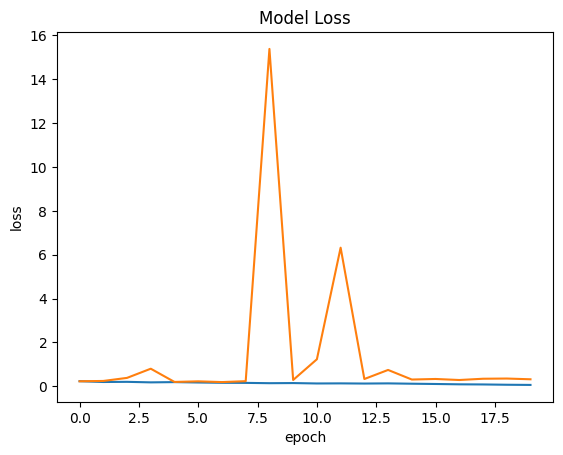

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

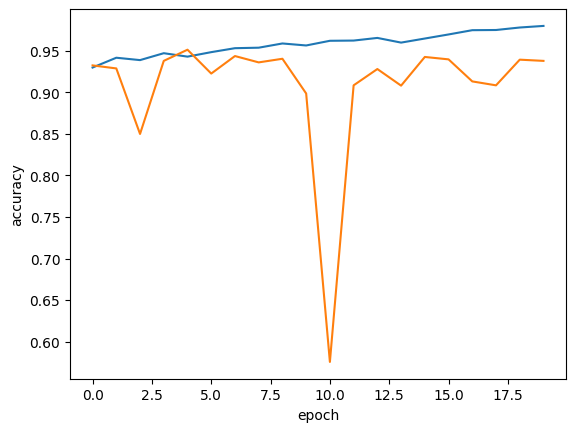

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

## Evaluation

In [ ]:
test_dataset=test_dataset.batch(1)

In [ ]:
model.evaluate(test_dataset)

87/87 [==============================] - 18s 63ms/step - loss: 0.3313 - accuracy: 0.9318


[0.33128663897514343, 0.9318099617958069]

In [ ]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 13s 13s/step


6.567142e-05

In [ ]:
def check(x):
  if(x<0.5):
    return str('Parasitized')
  else:
    return str("Un Infected")

1/1 [==============================] - 0s 27ms/step


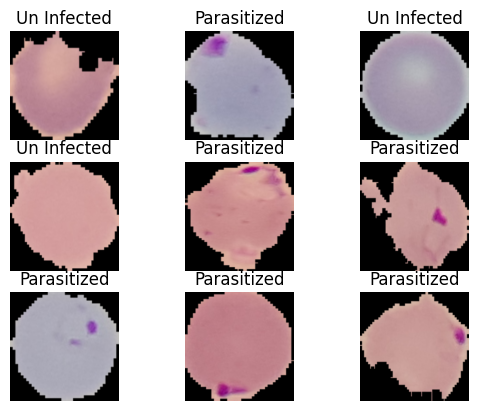

In [ ]:
for i,(image,label) in enumerate(test_dataset.take(9)):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(check(model.predict(image)[0][0])))
  plt.axis('off')